<a href="https://colab.research.google.com/github/pyagoubi/Motorcycle-data/blob/main/Motorcycle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [215]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [281]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.cluster import KMeans

In [232]:
data = pd.read_csv('/content/drive/MyDrive/upwork1/DATA1.TXT', sep=',')
data['Gx clean'] = data['Gx']-data['Gx Cal']
data['Gy clean'] = data['Gy']-data['Gy Cal']

In [282]:
#Parameters

#Step 1
shift_p = 10
Gy_min = 11

#Step 2
shift_a = 30
degree_min = 50

#Step 1

Determining local Maxima/ Minima based on Longitude/ Latitude Data

In [275]:
#calculate the distance on Longitude/ Latitude plane assuming 2D plane

def local_maxmin(df, shift = shift_p):

  df['corner'] = 0
  
  for i in df['SessionID'].unique():

    data = df[df['SessionID'] == i]

    data['Lat diff'] = data['Latitude'] - data['Latitude'].shift(shift)
    data['Lon diff'] = data['Longitude'] - data['Longitude'].shift(shift)

    data['Lat mdiff'] = data['Latitude'].shift(-shift) - data['Latitude']
    data['Lon mdiff'] = data['Longitude'].shift(-shift) - data['Longitude']

    data.loc[((data['Lat mdiff'] > 0) & (data['Lat diff'] < 0))| ((data['Lat mdiff'] < 0) & (data['Lat diff'] > 0)) 
    | ((data['Lon mdiff'] > 0) & (data['Lon diff'] < 0))
    | ((data['Lon mdiff'] < 0) & (data['Lon diff'] >= 0)), 'corner'] = 1 

    df.loc[df['SessionID'] == i, 'corner'] = data['corner'] 
  
  plt.scatter(x=data['Longitude'], y=data['Latitude'])
  plt.scatter(x=data.loc[data['corner'] == 1, 'Longitude'], y=data.loc[data['corner'] == 1,'Latitude'], color = 'y')

  return df




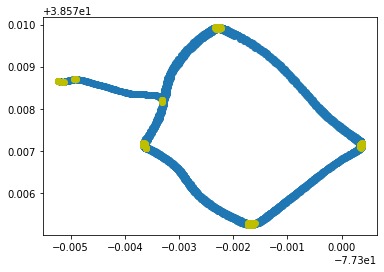

In [276]:
data = local_maxmin(data, shift = shift_p)

In [214]:
# #Points on the left can be eliminated by setting Gy-value (absolute) to >11, but then we lose data from the first lap

# plt.scatter(x=data['Longitude'], y=data['Latitude'])
# plt.scatter(x=data.loc[(data['corner'] == 1) & (data['Gy clean'].abs() >Gy_min), 'Longitude'], y=data.loc[(data['corner'] == 1) 
# & (data['Gy clean'].abs() >Gy_min),'Latitude'], color = 'y')

#Step 2

Determining corners by calculating angles between points


In [271]:
def angle_corner(df, shift_parameter = shift_a, degree_pm = degree_min):

  df['degrees'] = 0
  df['corner_a'] = 0

  for i in df['SessionID'].unique():
    
    
    data = df[df['SessionID'] == i]

    # Convert the points to numpy latitude/longitude radians space

    data['Lat converted'] = np.radians(data['Latitude'])
    data['Lon converted'] = np.radians(data['Longitude'])

    #past reference point
    data['Lat before'] = data['Lat converted'].shift(shift_parameter)
    data['Lon before'] = data['Lon converted'].shift(shift_parameter)

    #future reference point
    data['Lat after'] = data['Lat converted'].shift(-shift_parameter)
    data['Lon after'] = data['Lon converted'].shift(-shift_parameter)


    # Vectors in latitude/longitude space
    data['vector prev'] = (np.array(data[['Lat converted', 'Lon converted']]) - np.array(data[['Lat before', 'Lon before']])).tolist()
    data['vector past'] = (np.array(data[['Lat converted', 'Lon converted']]) - np.array(data[['Lat after', 'Lon after']])).tolist()


    for j in range(len(data)):
      if np.isnan(data['vector prev'][j][0]) == False:
        data.iloc[j, data.columns.get_loc('degrees')] = np.degrees(math.acos(np.dot(data['vector prev'][j], data['vector past'][j]) / (np.linalg.norm(data['vector prev'][j]) * np.linalg.norm(data['vector past'][j]) +1e-20)))
        #print(data.iloc[i, data.columns.get_loc('degrees')])
    
    data.loc[(data['degrees'] < (180 - degree_pm) )  |  (data['degrees'] > (180 + degree_pm) )    , 'corner_a'] = 1

    df.loc[df['SessionID'] == i, 'corner_a'] = data['corner_a']
    df.loc[df['SessionID'] == i, 'degrees'] = data['degrees'] 


  plt.scatter(x=df['Longitude'], y=df['Latitude'])
  plt.scatter(x=df.loc[(df['corner_a'] == 1), 'Longitude'], y=df.loc[(df['corner_a'] == 1),'Latitude'], color = 'y')  

  return df


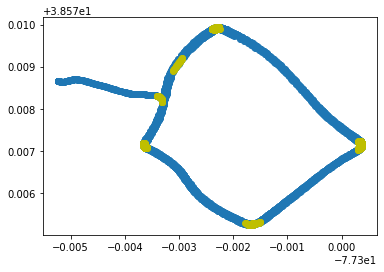

In [283]:
data = angle_corner(data, shift_parameter = shift_a, degree_pm = degree_min)

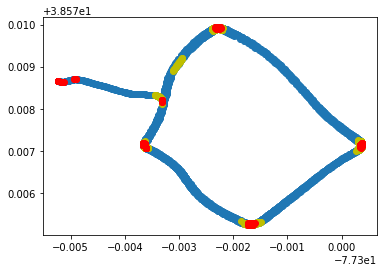

In [280]:
# combined

plt.scatter(x=data['Longitude'], y=data['Latitude'])
plt.scatter(x=data.loc[(data['corner_a'] == 1), 'Longitude'], y=data.loc[(data['corner_a'] == 1),'Latitude'], color = 'y') 
plt.scatter(x=data.loc[data['corner'] == 1, 'Longitude'], y=data.loc[data['corner'] == 1,'Latitude'], color = 'r')

# Determine corner centers


In [296]:
def cornercenters(df, clusters):

  kmeans = KMeans(n_clusters=6)
  kmeans.fit(data.loc[data['corner_a']==1, ['Longitude', 'Latitude']])
  centroids  = kmeans.cluster_centers_

  x = centroids[:, 0]
  y = centroids[:, 1]

  plt.scatter(x=df['Longitude'], y=df['Latitude'])
  plt.scatter(x=df.loc[(df['corner_a'] == 1), 'Longitude'], y=df.loc[(data['corner_a'] == 1),'Latitude'], color = 'y') 
  plt.scatter(x=x, y=y, color = 'r')

  return centroids

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


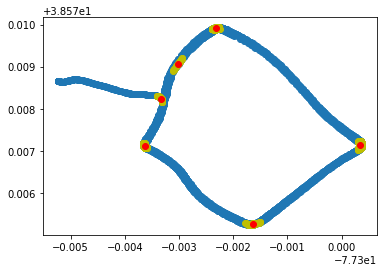

In [297]:
corners = cornercenters(data, clusters=6)